# Model Monitoring for Brain Image Segmentation

## Import data

In [1]:
import os

In [2]:
DATA_PATH='data/brain'
# TODO : Extract part of the function

def downloadBrainData(relPath = DATA_PATH, customUrl = None):

    download_command = "wget https://surfer.nmr.mgh.harvard.edu/ftp/dist/freesurfer/synthstrip/synthstrip_data_v1.2.tar.gz"
    if relPath is not None:
        download_command += " -P {}".format(relPath)
    
    if not os.path.exists(os.path.join(relPath, "synthstrip_data_v1.2.tar.gz")):
        !{download_command}
    


In [3]:
downloadBrainData(relPath=DATA_PATH)

In [4]:
extract_command = "tar -xf {REL_PATH}/synthstrip_data_v1.2.tar.gz -C {REL_PATH}/".format(REL_PATH='./data/brain')
!{extract_command}

## Data Prepatation

In [1]:
import os
import numpy as np
from utils import generate_patient_info_brain, preprocess_brain, structure_dataset, find_segmentations, median_spacing_target

/home/thiry/quality_control_CMR/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
segmentations_paths = find_segmentations(root_dir="data/brain/synthstrip_data_v1.2/", keywords=["mask"])
structure_dataset(data_path = DATA_PATH, segmentation_paths=segmentations_paths, delete="synthstrip_data_v1.2")

In [ ]:
patient_info = generate_patient_info_brain(data_path=DATA_PATH)

In [2]:
preprocess_brain(data_path=DATA_PATH)

## Dataset

In [8]:
import os
import numpy as np
import random
import torchvision
from utils import AddPadding, CenterCrop, OneHot, ToTensor, MirrorTransform, SpatialTransform
from utils import train_val_test

In [3]:
train_ids, val_ids, test_ids = train_val_test(data_path=DATA_PATH)

In [9]:


transform = torchvision.transforms.Compose([
    AddPadding((256,256)),
    CenterCrop((256,256)),
    OneHot(),
    ToTensor()
])
transform_augmentation = torchvision.transforms.Compose([
    MirrorTransform(),
    SpatialTransform(patch_size=(256,256), angle_x=(-np.pi/6,np.pi/6), scale=(0.7,1.4), random_crop=True),
    OneHot(),
    ToTensor()
])

## Training

In [5]:
import sys, importlib
import CA
import utils
importlib.reload(sys.modules['CA'])
importlib.reload(sys.modules['utils'])

import torch
import os
import numpy as np
from CA import AE, plot_history, hyperparameter_tuning
from utils import SYNDalaLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#the following cell allows the user to tune his own hyperparameters. In case you wanna try our hyperparameters first, just skip this cell.
RUN = False
#this is a list of possible values being tested for each hyperparameter.
parameters = {
    "DA": [True, False], #data augmentation
    "latent_size": [100, 500], #size of the latent space of the autoencoder
    "BATCH_SIZE": [8, 16, 4],
    "optimizer": [torch.optim.Adam],
    "lr": [2e-4, 1e-4, 1e-3],
    "weight_decay": [1e-5],
    "tuning_epochs": [5, 10], #number of epochs each configuration is run for
    "functions": [["GDLoss", "MSELoss"], ["GDLoss"], ["BKGDLoss", "BKMSELoss"]], #list of loss functions to be evaluated. BK stands for "background", which is a predominant and not compulsory class (it can lead to a dumb local minimum retrieving totally black images).
    "settling_epochs_BKGDLoss": [10, 0], #during these epochs BK has half the weight of LV, RV and MYO in the evaluation of BKGDLoss
    "settling_epochs_BKMSELoss": [10, 0], #during these epochs BK has half the weight of LV, RV and MYO in the evaluation of BKMSELoss
}

#this is a list of rules cutting out some useless combinations of hyperparameters from the tuning process.
rules = [
    '"settling_epochs_BKGDLoss" == 0 or "BKGDLoss" in "functions"',
    '"settling_epochs_BKMSELoss" == 0 or "BKMSELoss" in "functions"',
    '"BKGDLoss" not in "functions" or "settling_epochs_BKGDLoss" <= "tuning_epochs"',
    '"BKMSELoss" not in "functions" or "settling_epochs_BKMSELoss" <= "tuning_epochs"',
    #'"BKGDLoss" not in "functions" or "settling_epochs_BKGDLoss" >= "settling_epochs_BKMSELoss"'
]
if RUN: 
    optimal_parameters = hyperparameter_tuning(
        parameters,
        SYNDalaLoader("data/brain/preprocessed/", patient_ids=train_ids, batch_size=None, transform=None),
        SYNDalaLoader("data/brain/preprocessed/", patient_ids=val_ids, batch_size=None, transform=None),
        transform, transform_augmentation,
        rules,
        fast=True) #very important parameter. When False, all combinations are tested to return the one retrieving the maximum DSC. When True, the first combination avoiding dumb local minima is returned.


    np.save(os.path.join("data/brain/preprocessed/", "optimal_parameters"), optimal_parameters)

In [ ]:
upload_your_own_parameters = False

if upload_your_own_parameters:
    optimal_parameters = np.load(os.path.join("data/brain/preprocessed", "optimal_parameters.npy"), allow_pickle=True).item()
else:
    optimal_parameters = {
        "BATCH_SIZE": 8,
        "DA": False,
        "latent_size": 100,
        "optimizer": torch.optim.Adam,
        "lr": 2e-4,
        "weight_decay": 1e-5,
        "functions": ["BKGDLoss", "BKMSELoss"],
        "settling_epochs_BKGDLoss": 10,
        "settling_epochs_BKMSELoss": 0
    }
    np.save(os.path.join(DATA_PATH, "preprocessed/", "optimal_parameters"), optimal_parameters)

assert optimal_parameters is not None, "Be sure to continue with a working set of hyperparameters"

BATCH_SIZE = optimal_parameters["BATCH_SIZE"]
DA = optimal_parameters["DA"]

ae = AE(**optimal_parameters).to(device)

ckpt = None
if ckpt is not None:
    ckpt = torch.load(ckpt)
    ae.load_state_dict(ckpt["AE"])
    ae.optimizer.load_state_dict(ckpt["AE_optim"])
    start = ckpt["epoch"]+1
else:
    start = 0

# print(ae)

plot_history(
    ae.training_routine(
        range(start,500),
        SYNDalaLoader(data_path=DATA_PATH, mode='train', batch_size=BATCH_SIZE, transform=transform_augmentation if DA else transform),
        SYNDalaLoader(data_path=DATA_PATH, mode='val', batch_size=BATCH_SIZE, transform=transform),
        os.path.join(DATA_PATH, "checkpoints")
    )
)

Epoch [102]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0068	0.0027	0.0094	0.9957	10.764	0.9821	6.3479	0.0000	nan	0.0000	nan	
Epoch [103]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0071	0.0028	0.0099	0.9956	10.384	0.9812	6.2634	0.0000	nan	0.0000	nan	
Epoch [104]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0067	0.0027	0.0093	0.9958	10.644	0.9823	6.2950	0.0000	nan	0.0000	nan	
Epoch [105]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0066	0.0026	0.0093	0.9958	10.622	0.9824	6.3252	0.0000	nan	0.0000	nan	
Epoch [106]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0073	0.0030	0.0103	0.9954	10.534	0.9805	6.3733	0.0000	nan	0.0000	nan	
Epoch [107]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
0.0069	0.0027	0.0096	0.9957	10.406	0.9819	6.1987	0.0000	nan	0.0000	nan	
Epoch [108]
BKGDLo	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	

## Testing

In [1]:
import os
import numpy as np
import torch
import nibabel as nib
import torchvision

from CA import AE
from utils import postprocess_image_brain, evaluate_metrics, testing_brain, median_spacing_target
from utils import display_image, display_difference, process_results, display_plots, SYNDalaLoader
from utils import AddPadding, CenterCrop, OneHot, ToTensor, MirrorTransform, SpatialTransform
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform = torchvision.transforms.Compose([
    AddPadding((256,256)),
    CenterCrop((256,256)),
    OneHot(),
    ToTensor()
])
transform_augmentation = torchvision.transforms.Compose([
    MirrorTransform(),
    SpatialTransform(patch_size=(256,256), angle_x=(-np.pi/6,np.pi/6), scale=(0.7,1.4), random_crop=True),
    OneHot(),
    ToTensor()
])

In [3]:
optimal_parameters = np.load(os.path.join("data/brain/preprocessed", "optimal_parameters.npy"), allow_pickle=True).item()
assert optimal_parameters is not None, "Be sure to continue with a working set of hyperparameters"

ae = AE(**optimal_parameters).to(device)
ae.load_checkpoint(data_path=DATA_PATH, checkpoint_path='data/brain/checkpoints/209_best.pth', eval=True)

Chosen checkpoint is 209_best.pth .
###################################


In [5]:
patient_info = np.load("data/brain/preprocessed/patient_info.npy", allow_pickle=True).item()
current_spacing = median_spacing_target("data/brain/preprocessed/", 2)
test_ids = np.load('./data/brain/saved_ids.npy', allow_pickle=True).item().get('test_ids')

In [4]:
BATCH_SIZE=optimal_parameters['BATCH_SIZE']
test_loader = SYNDalaLoader(data_path = 'data/brain', mode='test', batch_size=BATCH_SIZE, transform=transform)

results = testing_brain(ae=ae, test_loader=test_loader, patient_info=patient_info, folder_predictions="data/brain/structured/", folder_out="data/brain/reconstructions", current_spacing=current_spacing)

NameError: name 'patient_info' is not defined

# Analysis
## General

In [ ]:
from utils import generate_testing_set
from model import alter_image

generate_testing_set(ae=ae, data_path= 'data/brain', alter_image = alter_image, transform = transform)

In [4]:
from utils import compute_results, plot_results
import matplotlib.pyplot as plt

results = compute_results(data_path='data/brain/', measures='both')

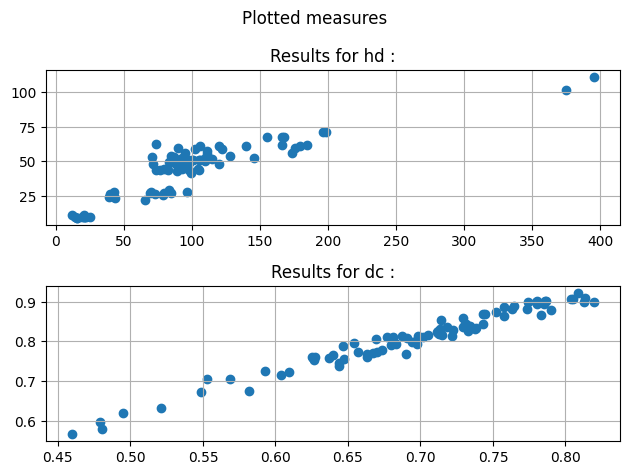

In [5]:
# results = np.load('data/brain/results.npy', allow_pickle=True).item()
plot_results(results)

## Single Patient

In [30]:
from utils import display_image, display_difference

In [31]:
patient_id = 236

prediction = np.round(nib.load("data/brain/structured/patient{:03d}/mask.nii.gz".format(patient_id)).get_fdata().transpose(2, 1, 0),2)
reconstruction = np.round(nib.load("data/brain/reconstructions/patient{:03d}/mask.nii.gz".format(patient_id)).get_fdata().transpose(2, 1, 0),2)

mid_frame = prediction.shape[0]//2

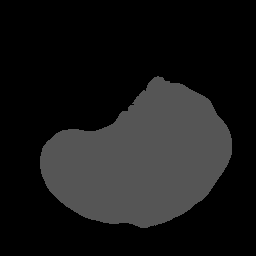

In [32]:
display_image(prediction[mid_frame])

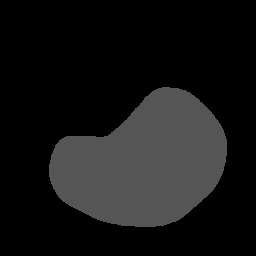

In [33]:
display_image(reconstruction[mid_frame])

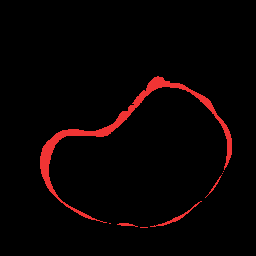

In [34]:
display_difference(reconstruction[mid_frame], prediction[mid_frame])